In [928]:
import pickle
import itertools
import numpy as np
from scipy import spatial
from scipy.stats import norm
import nltk.data
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import reuters
from nltk. corpus import gutenberg
from nltk.corpus import brown
from nltk.tokenize import sent_tokenize
from gensim.models import KeyedVectors
from keras.layers import Input, Dense, Lambda, Layer, LSTM, Reshape, TimeDistributed, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras import backend as K
from keras import metrics
import gensim.downloader as api

from gensim.models.word2vec import Word2Vec
import pandas as pd
import re
import matplotlib.pyplot as plt

# Preprocessing Text

The preprocessing code is data specific.  
  
It is an example of how one can use a pre-trained word2vec to embed sentences into a vector space.

# TODO train w2v model

In [226]:
corpus = api.load('20-newsgroups')
# info = api.info()  # show info about available models/datasets
# word2vec_model = api.load("glove-twitter-100")  # download the model and return as object ready for use
# word2vec_model.most_similar("cat")

In [227]:
dataset = pd.read_csv("shortjokes.csv").set_index("ID")

In [228]:
dataset_1 = pd.read_csv("jokes_score_name_clean.csv")

In [234]:
dataset_1["Joke"] = dataset_1["q"] + " " + dataset_1["a"]

In [237]:
dataset_2 = pd.read_csv("qajokes1.1.2.csv")
dataset_2["Joke"] = dataset_2["Question"] + " " + dataset_2["Answer"]

In [374]:
sentences = dataset["Joke"].tolist() + dataset_1["Joke"].tolist() + dataset_2["Joke"].tolist()

In [375]:
def preprocess_text(text):
    return re.sub(
        r"[^\w\s']", 
        "", 
        text
    ).lower().split()

In [376]:
preprocessed_sentences = [preprocess_text(t) for t in sentences]

In [377]:
len(sentences)

440099

In [382]:
w2v_model = Word2Vec(preprocessed_sentences, size=100, window=10, workers=16, iter=100)
# w2v_model = word2vec_model

In [383]:
w2v_model.wv.most_similar("bolt")

[('phelps', 0.5148839950561523),
 ("bolt's", 0.5110259056091309),
 ('bloodbath', 0.45941269397735596),
 ('gust', 0.4141930341720581),
 ('nada', 0.4051152169704437),
 ('glimpse', 0.40208110213279724),
 ('key', 0.3946117162704468),
 ('ricocheted', 0.39381635189056396),
 ('lightning', 0.38503432273864746),
 ('binos', 0.38127273321151733)]

In [389]:
w2v = w2v_model.wv

Preprocessing text from a variety of different sources.

(array([ 45000., 233729., 105550.,  20059.,   4429.,   2733.,   2216.,
          2010.,   1910.,   1746.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

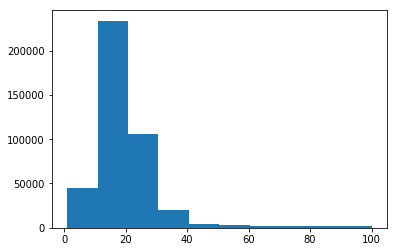

In [632]:
plt.hist([len(s) + 1 for s in preprocessed_sentences if len(s) < 100])

# No LSTM variant

In [418]:
# def vectorize_sentence(sentence):
#     concat_vector = []
#     for word in sentence:
#         try:
#             concat_vector.append(w2v[word])
#         except:
#             return
#     return [a for vector in concat_vector for a in vector]

In [899]:
# vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 15) & (len(sentence) > 10)]

In [905]:
# vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [890]:
# from keras.preprocessing import sequence
# vectorized_padded = sequence.pad_sequences(vectorized_sentences, maxlen=original_dim, padding="post", truncating="post")

In [898]:
# normalized_vectorized_padded = (vectorized_padded - vectorized_padded.min()) / (vectorized_padded.max() - vectorized_padded.min())# + 0.01*np.random.randn(*normalized_vectorized_padded.shape)

In [919]:
# original_dims = 1500

# LSTM variant

In [957]:
def vectorize_sentence(sentence):
    concat_vector = []
    for word in sentence:
        try:
            concat_vector.append(w2v[word])
        except:
            return
    return concat_vector

In [958]:
vectorized_sentences = [vectorize_sentence(sentence) for sentence in preprocessed_sentences if (len(sentence) < 15) & (len(sentence) > 10)]

In [961]:
vectorized_sentences = [sentence for sentence in vectorized_sentences if sentence]

In [969]:
vectorized_padded = np.array([sentence + [[0] * 100] * (15 - len(sentence)) for sentence in vectorized_sentences])

In [970]:
vectorized_padded.min()

-17.024572372436523

In [967]:
len(vectorized_padded[0])

15

In [971]:
vectorized_padded_min = np.min(vectorized_padded)
vectorized_padded_max = np.max(vectorized_padded)

In [972]:
normalized_vectorized_padded = vectorized_padded

In [986]:
original_dims = (15, 100)
original_dim = 1500

It's important to shuffle the text vectors before splitting them into test and train samples.   
  
This is done to avoid clumping text with similar context and style in the dataset because it can confuse the neural network during training.

In [920]:
from sklearn.model_selection import train_test_split

In [974]:
vectorized_train, vectorized_test = train_test_split(normalized_vectorized_padded, test_size=0.3)

In [975]:
batch_size = 500
def cut_dataset(dataset, batch_size):
    rest = len(dataset) % batch_size
    return dataset[:-rest]

vectorized_train = cut_dataset(vectorized_train, batch_size)
vectorized_test = cut_dataset(vectorized_test, batch_size)

In [985]:
help_vectorized_train = vectorized_train.reshape(-1, 1500)
help_vectorized_test = vectorized_test.reshape(-1, 1500)

Get w2v embeddings for text with fixed length

# Variational Autoencoder

1. Values was not in diapason
2. LSTM usage in encoder

In [987]:
from keras import callbacks

In [998]:
latent_dim = 32
lstm_dim = 100
intermediate_dim = 100
epochs = 200
epsilon_std = 1.

In [999]:
x = Input(shape=original_dims)
h = Bidirectional(LSTM(lstm_dim, return_sequences=False), merge_mode='concat')(x)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)
h_mean = Dense(latent_dim, activation='relu')(h)
z_mean = Dense(latent_dim)(h_mean)
h_log_var = Dense(latent_dim, activation='relu')(h)
z_log_var = Dense(latent_dim)(h_log_var)

In [1000]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [1001]:
# we instantiate these layers separately so as to reuse them later
def custom_sigmoid(x):
    return K.sigmoid(x) 
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid') 
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [1002]:
def vae_loss(y_true, y_pred):
    xent_loss = K.sum(K.binary_crossentropy(y_pred, y_true), axis=-1)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var, axis=-1)
    return xent_loss + kl_loss

In [1003]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss, metrics=["accuracy"])

In [1004]:
#### checkpoint
cp = [callbacks.ModelCheckpoint(filepath="/tmp/model.h5", verbose=1)]

#train
vae.fit(vectorized_train, help_vectorized_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(vectorized_test, help_vectorized_test),
        callbacks=cp)

Train on 61000 samples, validate on 26000 samples
Epoch 1/200
61000/61000 [==============================] - 13s 217us/step - loss: 7482.4536 - acc: 0.0033 - val_loss: 7009.0840 - val_acc: 0.0014

Epoch 00001: saving model to /tmp/model.h5
Epoch 2/200
61000/61000 [==============================] - 9s 154us/step - loss: 6978.4911 - acc: 0.0068 - val_loss: 6914.4647 - val_acc: 0.0082

Epoch 00002: saving model to /tmp/model.h5
Epoch 3/200
61000/61000 [==============================] - 9s 153us/step - loss: 6815.9899 - acc: 0.0026 - val_loss: 6708.4793 - val_acc: 0.0013

Epoch 00003: saving model to /tmp/model.h5
Epoch 4/200
61000/61000 [==============================] - 9s 156us/step - loss: 6667.3652 - acc: 0.0021 - val_loss: 6626.5005 - val_acc: 0.0025

Epoch 00004: saving model to /tmp/model.h5
Epoch 5/200
61000/61000 [==============================] - 9s 155us/step - loss: 6604.5412 - acc: 0.0033 - val_loss: 6577.2451 - val_acc: 0.0056

Epoch 00005: saving model to /tmp/model.h5
Epoc

61000/61000 [==============================] - 9s 152us/step - loss: 6061.8640 - acc: 0.1439 - val_loss: 6089.3466 - val_acc: 0.1428

Epoch 00044: saving model to /tmp/model.h5
Epoch 45/200
61000/61000 [==============================] - 9s 153us/step - loss: 6056.2081 - acc: 0.1447 - val_loss: 6084.3554 - val_acc: 0.1452

Epoch 00045: saving model to /tmp/model.h5
Epoch 46/200
61000/61000 [==============================] - 9s 155us/step - loss: 6050.3209 - acc: 0.1458 - val_loss: 6078.1991 - val_acc: 0.1456

Epoch 00046: saving model to /tmp/model.h5
Epoch 47/200
61000/61000 [==============================] - 9s 153us/step - loss: 6043.5149 - acc: 0.1464 - val_loss: 6072.8964 - val_acc: 0.1463

Epoch 00047: saving model to /tmp/model.h5
Epoch 48/200
61000/61000 [==============================] - 9s 155us/step - loss: 6038.1277 - acc: 0.1462 - val_loss: 6069.0397 - val_acc: 0.1448

Epoch 00048: saving model to /tmp/model.h5
Epoch 49/200
61000/61000 [==============================] - 10s

61000/61000 [==============================] - 9s 154us/step - loss: 5901.7844 - acc: 0.1510 - val_loss: 5958.6137 - val_acc: 0.1500

Epoch 00087: saving model to /tmp/model.h5
Epoch 88/200
61000/61000 [==============================] - 9s 152us/step - loss: 5899.2612 - acc: 0.1511 - val_loss: 5957.7933 - val_acc: 0.1502

Epoch 00088: saving model to /tmp/model.h5
Epoch 89/200
61000/61000 [==============================] - 9s 152us/step - loss: 5896.2993 - acc: 0.1511 - val_loss: 5955.2818 - val_acc: 0.1501

Epoch 00089: saving model to /tmp/model.h5
Epoch 90/200
61000/61000 [==============================] - 9s 154us/step - loss: 5893.4533 - acc: 0.1511 - val_loss: 5953.6463 - val_acc: 0.1502

Epoch 00090: saving model to /tmp/model.h5
Epoch 91/200
61000/61000 [==============================] - 9s 154us/step - loss: 5891.2176 - acc: 0.1511 - val_loss: 5951.9048 - val_acc: 0.1502

Epoch 00091: saving model to /tmp/model.h5
Epoch 92/200
61000/61000 [==============================] - 9s 

61000/61000 [==============================] - 9s 155us/step - loss: 5792.0985 - acc: 0.1511 - val_loss: 5870.4695 - val_acc: 0.1502

Epoch 00130: saving model to /tmp/model.h5
Epoch 131/200
61000/61000 [==============================] - 9s 152us/step - loss: 5789.3887 - acc: 0.1511 - val_loss: 5868.8295 - val_acc: 0.1502

Epoch 00131: saving model to /tmp/model.h5
Epoch 132/200
61000/61000 [==============================] - 9s 155us/step - loss: 5787.1100 - acc: 0.1511 - val_loss: 5867.6909 - val_acc: 0.1502

Epoch 00132: saving model to /tmp/model.h5
Epoch 133/200
61000/61000 [==============================] - 9s 150us/step - loss: 5785.0555 - acc: 0.1511 - val_loss: 5864.3594 - val_acc: 0.1502

Epoch 00133: saving model to /tmp/model.h5
Epoch 134/200
61000/61000 [==============================] - 9s 155us/step - loss: 5780.6153 - acc: 0.1511 - val_loss: 5860.9543 - val_acc: 0.1502

Epoch 00134: saving model to /tmp/model.h5
Epoch 135/200
61000/61000 [==============================] 

61000/61000 [==============================] - 9s 152us/step - loss: 5697.6331 - acc: 0.1511 - val_loss: 5792.5419 - val_acc: 0.1502

Epoch 00173: saving model to /tmp/model.h5
Epoch 174/200
61000/61000 [==============================] - 9s 152us/step - loss: 5695.3853 - acc: 0.1511 - val_loss: 5792.0061 - val_acc: 0.1502

Epoch 00174: saving model to /tmp/model.h5
Epoch 175/200
61000/61000 [==============================] - 10s 157us/step - loss: 5694.1622 - acc: 0.1511 - val_loss: 5788.4963 - val_acc: 0.1502

Epoch 00175: saving model to /tmp/model.h5
Epoch 176/200
61000/61000 [==============================] - 10s 157us/step - loss: 5690.7874 - acc: 0.1511 - val_loss: 5787.6481 - val_acc: 0.1502

Epoch 00176: saving model to /tmp/model.h5
Epoch 177/200
61000/61000 [==============================] - 9s 156us/step - loss: 5688.9138 - acc: 0.1511 - val_loss: 5786.5314 - val_acc: 0.1502

Epoch 00177: saving model to /tmp/model.h5
Epoch 178/200
61000/61000 [==============================

In [1005]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [1006]:
vectorized_test[0:10].shape

(10, 15, 100)

In [881]:
len(vectorized_test[0:50])

50

In [1014]:
test_model = Model(x, z_log_var)
np.min(test_model.predict(vectorized_test[0:10])), np.max(test_model.predict(vectorized_test[0:10]))

(-6.77534, 0.021861387)

# Generating Text From Latent Space

In [1008]:
# some matrix magic
def sent_parse(sentence, mat_shape):
    data_concat = []
    word_vecs = vectorize_sentences(sentence)
    for x in word_vecs:
        data_concat.append(list(itertools.chain.from_iterable(x)))
    zero_matr = np.zeros(mat_shape)
    zero_matr[0] = np.array(data_concat)
    return zero_matr

In [1009]:
def print_sentence_with_w2v(sent_vect):
    sent_vect = sent_vect * (vectorized_padded.max() - vectorized_padded.min()) + vectorized_padded.min()
    word_sent = ''
    tocut = sent_vect
    for i in range (int(len(sent_vect)/100)):
        word_sent += w2v.most_similar(positive=[tocut[:100]], topn=1)[0][0]
        word_sent += ' '
        tocut = tocut[100:]
    print(word_sent)

In [1010]:
# input: encoded sentence vector
# output: encoded sentence vector in dataset with highest cosine similarity
def find_similar_encoding(sent_vect):
    all_cosine = []
    for sent in sent_encoded:
        result = 1 - spatial.distance.cosine(sent_vect, sent)
        all_cosine.append(result)
    data_array = np.array(all_cosine)
    maximum = data_array.argsort()[-3:][::-1][1]
    new_vec = sent_encoded[maximum]
    return new_vec

In [1011]:
# input: two points, integer n
# output: n equidistant points on the line between the input points (inclusive)
def shortest_homology(point_one, point_two, num):
    dist_vec = point_two - point_one
    sample = np.linspace(0, 1, num, endpoint = True)
    hom_sample = []
    for s in sample:
        hom_sample.append(point_one + s * dist_vec)
    return hom_sample

In [1012]:
# input: two written sentences, VAE batch-size, dimension of VAE input
# output: the function embeds the sentences in latent-space, and then prints their generated text representations
# along with the text representations of several points in between them
def sent_2_sent(sent1,sent2, batch, dim):
    a = sent_parse([sent1], (batch,dim))
    b = sent_parse([sent2], (batch,dim))
    encode_a = encoder.predict(a, batch_size = batch)
    encode_b = encoder.predict(b, batch_size = batch)
    test_hom = hom_shortest(encode_a[0], encode_b[0], 5)
    
    for point in test_hom:
        p = generator.predict(np.array([point]))[0]
        print_sentence(p)

Printing sentences from the training set and comparing them with the original will test whether the custom print function works properly.

In [1018]:
# sentences = [vectorize_sentence(preprocess_text("zero should be less than or equal to zero"))]
# padded_sentences = sequence.pad_sequences(sentences, maxlen=original_dim, padding="post", truncating="post")
padded_sentences = vectorized_train[0:10]

The encoder takes the training set of sentence vectors (concatenanted word vectors) and embeds them into a lower dimensional vector space.

In [1019]:
sent_encoded = encoder.predict(padded_sentences)

The decoder takes the list of latent dimensional encodings from above and turns them back into vectors of their original dimension.

In [1020]:
sent_decoded = generator.predict(sent_encoded)

In [1021]:
for sent in vectorized_train[0:10]:
    print_sentence_with_w2v(sent)

In [1022]:
vectorized_train[0].tolist()

[[3.230534076690674,
  1.7841397523880005,
  0.33554771542549133,
  -4.471125602722168,
  -10.429625511169434,
  -3.695082664489746,
  -0.583594799041748,
  -2.5402655601501465,
  3.05374813079834,
  1.3722996711730957,
  3.656583547592163,
  0.8342439532279968,
  1.7185630798339844,
  -5.148459434509277,
  1.1783592700958252,
  0.6966879963874817,
  0.06443650275468826,
  3.064058303833008,
  5.935538291931152,
  -0.010613851249217987,
  1.6359413862228394,
  2.384526014328003,
  -3.332228422164917,
  -2.9500839710235596,
  -1.9641884565353394,
  -2.8828322887420654,
  0.1282566636800766,
  4.546124458312988,
  5.479730129241943,
  1.7513734102249146,
  1.0384042263031006,
  -1.9057034254074097,
  -1.1147444248199463,
  -2.539559841156006,
  -1.3884321451187134,
  1.222303032875061,
  5.743267059326172,
  -0.8951510787010193,
  -0.9526766538619995,
  0.7061541676521301,
  5.5933990478515625,
  -4.280279159545898,
  -7.2838664054870605,
  -2.943571090698242,
  -6.801851749420166,
  -4.

In [738]:
sent_decoded[0].tolist()

[4.9988250732421875,
 4.592367649078369,
 2.8691295028693276e-06,
 8.436801726929843e-05,
 0.0030765836127102375,
 4.4009026169078425e-05,
 1.4098850442678668e-06,
 0.21443389356136322,
 4.99976921081543,
 4.989309787750244,
 4.998795509338379,
 1.0576161457720445e-06,
 1.2819693088531494,
 8.440025567324483e-09,
 4.847967624664307,
 1.4181325695972191e-06,
 1.3359247077460168e-06,
 4.981239318847656,
 4.972445487976074,
 0.06584279984235764,
 0.7508531212806702,
 4.999998092651367,
 1.2617031188710826e-06,
 1.2527779290394392e-05,
 1.5455980246770196e-06,
 3.783156671488541e-06,
 2.974584049297846e-06,
 4.997616767883301,
 4.99953556060791,
 4.999997138977051,
 4.999999523162842,
 0.00011452476610429585,
 1.7561302456670091e-06,
 0.0006354181095957756,
 0.000161038275109604,
 0.02514462172985077,
 4.999945640563965,
 0.16092371940612793,
 3.783816737268353e-06,
 0.043255798518657684,
 4.583837509155273,
 0.00796157494187355,
 2.851735985132109e-07,
 2.779670467134565e-06,
 0.000539138

In [1023]:
for i, sentence in enumerate(padded_sentences):
#     print("Original...")
#     print_sentence_with_w2v(sentence)
    print("Generated...")
    print_sentence_with_w2v(sent_decoded[i])
    print("===========================")

Generated...
what did the arctica robbin sherriff the the the his town robbin robbin robbin robbin 
Generated...
why did the papsmear robbin footrace earl's to somehow the somehow robbin robbin robbin robbin 
Generated...
what do you call a accross sherriff a the the the robbin robbin robbin robbin 
Generated...
how many jews does it spike to dared a the 15yo robbin robbin robbin robbin 
Generated...
why is the portugal pokemon so because because crusades robbin somehow robbin robbin robbin robbin 
Generated...
i just convince a portugal camaro somehow somehow just somehow somehow robbin robbin robbin robbin 
Generated...
i used to bowling a the another the arctica the castle robbin robbin robbin robbin 
Generated...
i just knew this monopoly whose camaro camaro littleknown a somehow robbin robbin robbin robbin 
Generated...
what does panzer a minigolf a and a the a the robbin robbin robbin robbin 
Generated...
why wasnt the cholo kick the the the marrow somehow somehow robbin robbin r

The encoder trained above embeds sentences (concatenated word vetors) into a lower dimensional space. The code below takes two of these lower dimensional sentence representations and finds five points between them. It then uses the trained decoder to project these five points into the higher, original, dimensional space. Finally, it reveals the text represented by the five generated sentence vectors by taking each word vector concatenated inside and finding the text associated with it in the word2vec used during preprocessing.

In [ ]:
test_hom = shortest_homology(sent_encoded[3], sent_encoded[10], 5)
for point in test_hom:
    p = generator.predict(np.array([point]))[0]
    print_sentence_with_w2v(p)

The code below does the same thing, with one important difference. After sampling equidistant points in the latent space between two sentence embeddings, it finds the embeddings from our encoded dataset those points are most similar to. It then prints the text associated with those vectors.
  
This allows us to explore how the Variational Autoencoder clusters our dataset of sentences in latent space. It lets us investigate whether sentences with similar concepts or grammatical styles are represented in similar areas of the lower dimensional space.

In [ ]:
test_hom = shortest_homology(sent_encoded[2], sent_encoded[1500], 20)
for point in test_hom:
    p = generator.predict(np.array([find_similar_encoding(point)]))[0]
    print_sentence_with_w2v(p)